# Node elevations and edge grades

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

OSMnx allows you to automatically add elevation attributes to your graph's nodes with the `elevation` module, using either local raster files or the Google Maps Elevation API as the elevation data source. If you use the Google API, you will need an API key. Once your nodes have elevation values, OSMnx can automatically calculate your edges' grades (inclines).

In [1]:
import sys

import numpy as np
import osmnx as ox
import pandas as pd

ox.__version__

'1.9.3'

## Elevation from local raster file(s)

OSMnx can attach elevations to graph nodes using either a single raster file or a list of raster files. The latter creates a virtual raster VRT composed of the rasters at those filepaths. By default, it uses all available CPUs but you can configure this with an argument.

In [2]:
address = "600 Montgomery St, San Francisco, California, USA"
G = ox.graph_from_address(address=address, dist=500, dist_type="bbox", network_type="bike")

In [3]:
# add node elevations from a single raster file
# some nodes will be null because the single file does not cover the graph's extents
raster_path = "./input_data/elevation1.tif"
G = ox.elevation.add_node_elevations_raster(G, raster_path, cpus=1)

In [4]:
# add node elevations from multiple raster files
# no nulls should remain
raster_paths = ["./input_data/elevation1.tif", "./input_data/elevation2.tif"]
G = ox.elevation.add_node_elevations_raster(G, raster_paths, cpus=1)
assert not np.isnan(np.array(G.nodes(data="elevation"))[:, 1]).any()

In [5]:
# add edge grades and their absolute values
G = ox.elevation.add_edge_grades(G, add_absolute=True)

## Elevation from Google Maps Elevation API

You will need a Google Maps Elevation [API key](https://developers.google.com/maps/documentation/elevation/start). Consider your API usage limits. OSMnx rounds coordinates to 5 decimal places (approx 1 meter) to fit 350 locations in a batch. Note that there is some spatial inaccuracy given Google's dataset's resolution. For example, in San Francisco (where the resolution is 19 meters) a couple of edges in hilly parks have a 50+ percent grade because Google assigns one of their nodes the elevation of a hill adjacent to the street.

In [ ]:
# replace this with your own API key!
try:
    from keys import google_elevation_api_key
except ImportError:
    sys.exit()  # you need an API key to proceed

In [ ]:
# get the street network for san francisco
place = "San Francisco"
place_query = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place_query, network_type="drive")

In [ ]:
# add elevation to each of the nodes, using the google elevation API, then calculate edge grades
G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
G = ox.elevation.add_edge_grades(G)

## Calculate some summary stats

Use an undirected representation of the network so we don't overcount two-way streets (because they have reciprocal edges pointing in each direction). We use the absolute value of edge grade because we're interested in steepness, not directionality.

In [6]:
# calculate the edges' absolute grades (and drop any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.convert.to_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

In [7]:
avg_grade = np.mean(grades)
print(f"Average street grade in {place} is {avg_grade * 100:.1f}%")

med_grade = np.median(grades)
print(f"Median street grade in {place} is {med_grade * 100:.1f}%")

NameError: name 'place' is not defined

## Plot the nodes by elevation

Plot them colored from low (violet) to high (yellow).

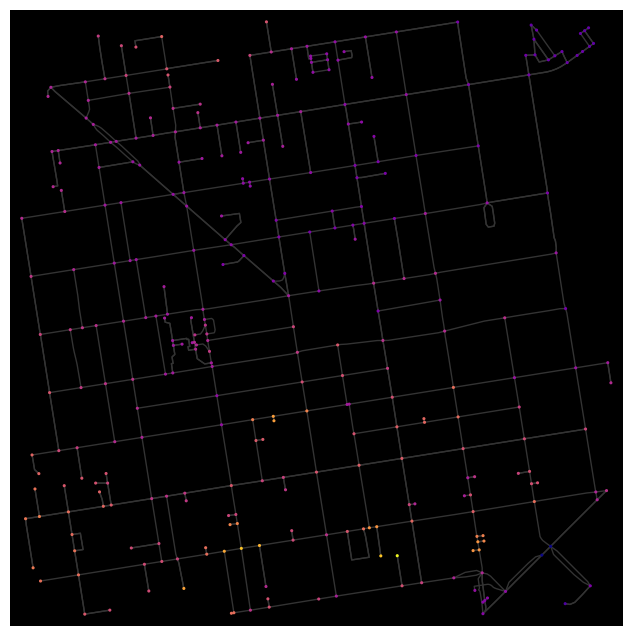

In [8]:
# get one color for each node, by elevation, then plot the network
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=5, edge_color="#333333", bgcolor="k")

## Plot the edges by grade

Grade is the ratio of elevation change to edge length. Plot edges colored from low/flat (violet) to high/steep (yellow).

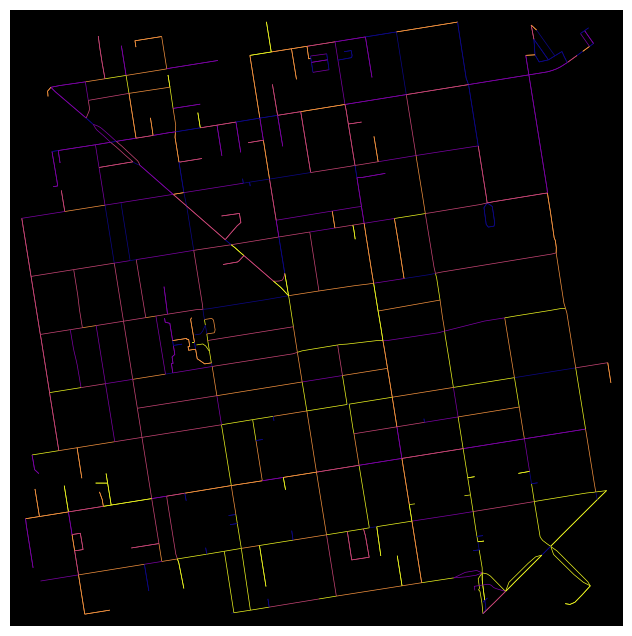

In [9]:
# get a color for each edge, by grade, then plot the network
ec = ox.plot.get_edge_colors_by_attr(G, "grade_abs", cmap="plasma", num_bins=5, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

## Calculate shortest paths, considering grade impedance

This example approximates the route of "The Wiggle" in San Francisco.

In [10]:
# select an origin and destination node and a bounding box around them
origin = ox.distance.nearest_nodes(G, -122.426, 37.77)
destination = ox.distance.nearest_nodes(G, -122.441, 37.773)
bbox = ox.utils_geo.bbox_from_point((37.772, -122.434), dist=1500)

In [11]:
# define some edge impedance function here


def impedance(length, grade):
    penalty = grade**2
    return length * penalty


# add impedance and elevation rise values to each edge in the projected graph
# use absolute value of grade in impedance function if you want to avoid uphill and downhill
for _, _, _, data in G.edges(keys=True, data=True):
    data["impedance"] = impedance(data["length"], data["grade_abs"])
    data["rise"] = data["length"] * data["grade"]

#### First find the shortest path that minimizes *trip distance*:

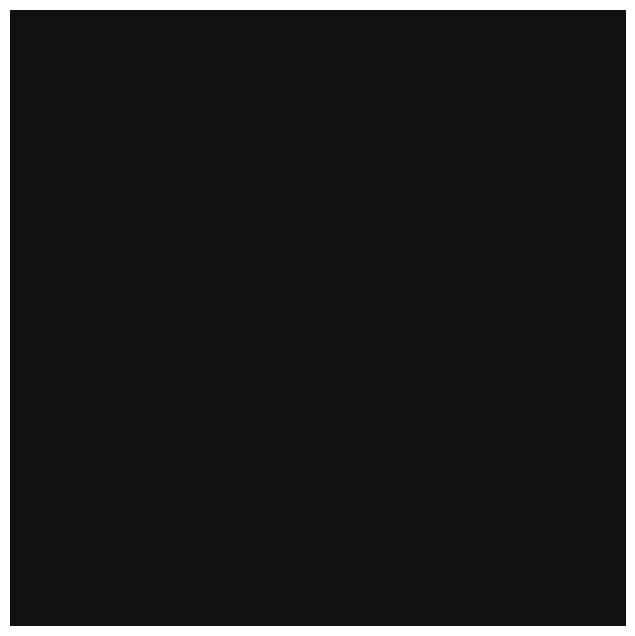

In [12]:
route_by_length = ox.shortest_path(G, origin, destination, weight="length")
fig, ax = ox.plot_graph_route(G, route_by_length, bbox=bbox, node_size=0)

#### Now find the shortest path that avoids slopes by minimizing *impedance* (function of length and grade):

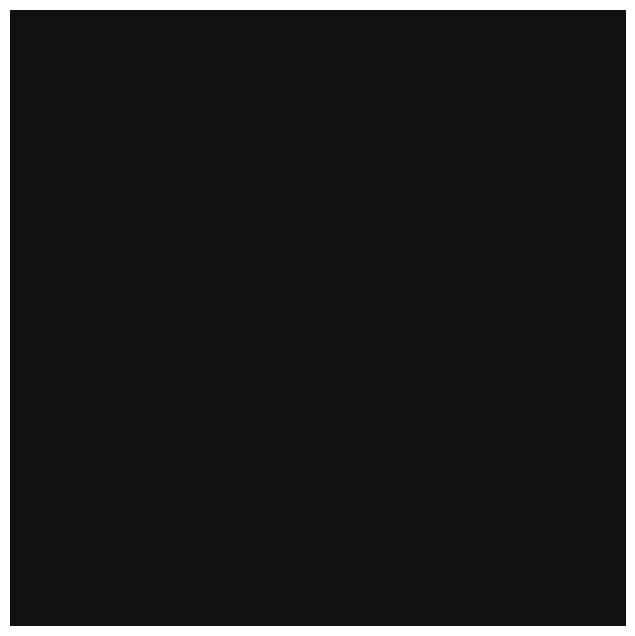

In [13]:
route_by_impedance = ox.shortest_path(G, origin, destination, weight="impedance")
fig, ax = ox.plot_graph_route(G, route_by_impedance, bbox=bbox, node_size=0)

#### Print some summary stats about these two routes:

In [14]:
def print_route_stats(route):
    route_grades = ox.routing.route_to_gdf(G, route, weight="grade_abs")["grade_abs"]
    msg = "The average grade is {:.1f}% and the max is {:.1f}%"
    print(msg.format(np.mean(route_grades) * 100, np.max(route_grades) * 100))

    route_rises = ox.routing.route_to_gdf(G, route, weight="rise")["rise"]
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = "Total elevation change is {:.1f} meters: {:.0f} meter ascent and {:.0f} meter descent"
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.routing.route_to_gdf(G, route, weight="length")["length"]
    print(f"Total trip distance: {np.sum(route_lengths):,.0f} meters")

In [15]:
# stats of route minimizing length
print_route_stats(route_by_length)

The average grade is 8.2% and the max is 14.9%
Total elevation change is 11.0 meters: 11 meter ascent and 0 meter descent
Total trip distance: 132 meters


In [16]:
# stats of route minimizing impedance (function of length and grade)
print_route_stats(route_by_impedance)

The average grade is 8.2% and the max is 14.9%
Total elevation change is 11.0 meters: 11 meter ascent and 0 meter descent
Total trip distance: 132 meters


So, we decreased the average slope along the route from a 5% grade to a 2% grade. The total elevation change is obviously (approximately, due to rounding) the same with either route, but using our impedance function we decrease the total ascent from 69 meters to 42 meters (but the trip distance increases from 1.9 km to 3.3 km).